# Graph Embedding with Color Refinement

This is a technique used to embed graphs into a feature space such that it preserves the count of  identical subgraphs between graphs with a 0% false negative rate and arbitrarily close to 0% false positive rate. 
 
This is useful for graph prediction tasks where the relevant features are identical subgraphs. The odds of a false postive increases with the size of the subgraphs.
 
This graph embedding algorithm + a Weighted Ensemble of LGBM models I  used to get first place in a [Molecule Classification competition hosted by the Therapeutic Data Commons](https://tdcommons.ai/benchmark/admet_group/10cyp2c9i/)
 
Primarily based on this lecture:
 
Stanford Online, Professor Jure Leskovec
[CS224W: Machine Learning with Graphs | 2021 | Lecture 2.3 - Traditional Feature-based Methods: Graph](https://www.youtube.com/watch?v=buzsHTa4Hgs&t=701s)
 
 
[Source Code for ColorRefinment](https://github.com/parkerburchett/TDC-DeepLearning/blob/main/utils/ColorRefinement.py)
 



In [1]:
import ColorRefinement as cr
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from pysmiles import read_smiles

In [33]:
def compute_mol_only_elements(smile):
    mol = read_smiles(smile)
    unique_elements = set()
    for n in mol.nodes:
        del mol.nodes[n]['charge']
        del mol.nodes[n]['hcount']
        del mol.nodes[n]['aromatic']
        try:
            del mol.nodes[n]['stereo']
        except:
            pass
    return mol

def show_mol_only_elements(mol):
    labels = nx.get_node_attributes(mol, 'element')
    plt.figure(figsize=(4,4)) 
    nx.draw_kamada_kawai(mol,labels=labels,node_size=1500, font_size=20)
    plt.show()


Two subgraphs with identical topology that are chemically distinct. In order to capture these differences the initial node color is set as a hash of node attributes.
 

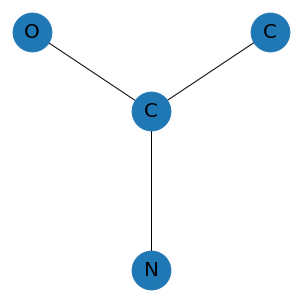

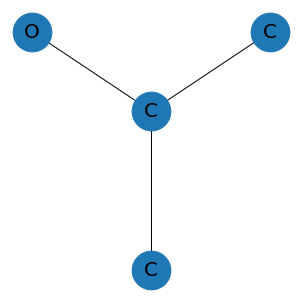

In [34]:
a ='CC(=O)N'
mol = compute_mol_only_elements(a)
show_mol_only_elements(mol)
b ='CC(=O)C'
mol = compute_mol_only_elements(b)
show_mol_only_elements(mol)

Atom "[C@@]" contains stereochemical information that will be discarded.


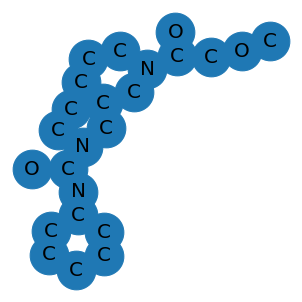

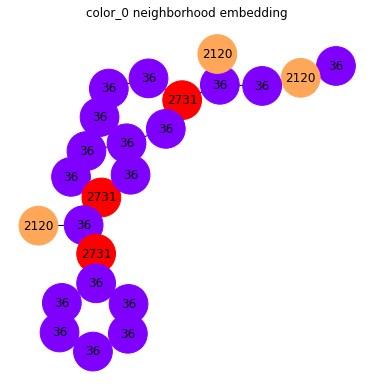

In [35]:
mol_1 = compute_mol_only_elements('COCC(=O)N1CCC[C@@]2(CCN(C(=O)Nc3ccccc3)C2)C1')
mol_2 = compute_mol_only_elements('COC(=O)N1CCC2(CCCN(C(=O)Nc3ccccc3)C2)CC1')

show_mol_only_elements(mol_1)
color_graph = cr._compute_K_color_refinements(G=mol_1,K=5, num_buckets=3000)
render_color_graph(color_graph, 'color_0')

# Color Refinement

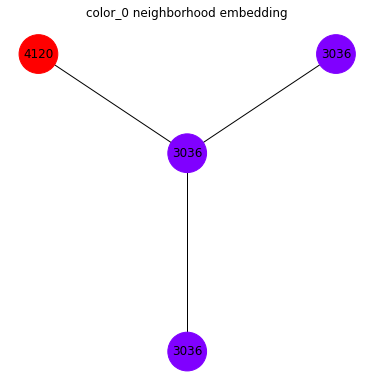

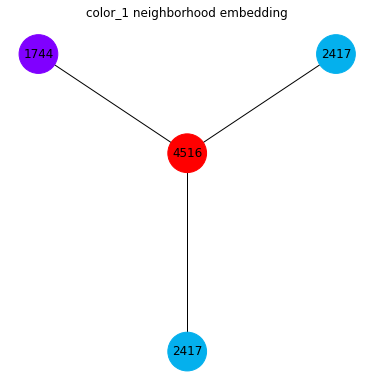

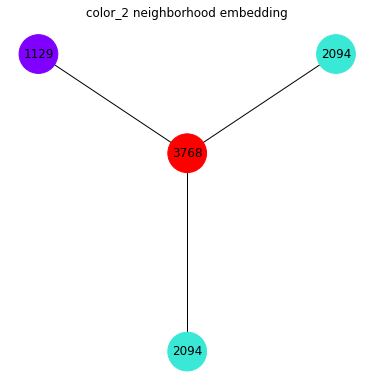

In [36]:
def render_color_graph(color_graph, color_number):
    labels = nx.get_node_attributes(color_graph, color_number)
    color_df = pd.DataFrame.from_dict(labels.items())
    color_df.columns = ['ID', 'COLOR']
    color_df
    plt.figure(figsize=(5,5)) 
    nx.draw_kamada_kawai(color_graph,
                        labels=labels,
                        node_size=1500,node_color=color_df['COLOR'],
                        cmap=plt.cm.rainbow)
    plt.title(f'{color_number} neighborhood embedding')
    plt.show()
color_graph = cr._compute_K_color_refinements(G=mol,K=5, num_buckets=5000)
render_color_graph(color_graph, 'color_0')
render_color_graph(color_graph, 'color_1')
render_color_graph(color_graph, 'color_2')

## Larger and Similar molecules

Atom "[C@@]" contains stereochemical information that will be discarded.


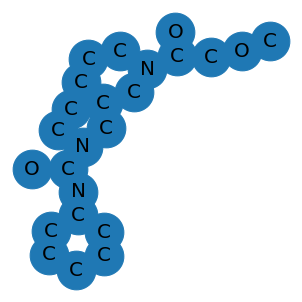

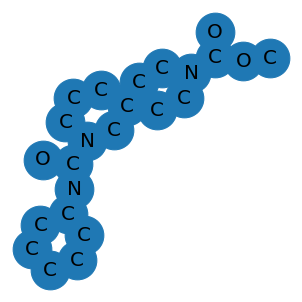

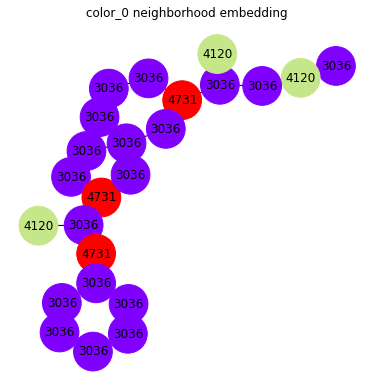

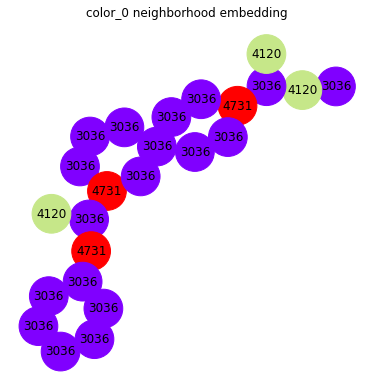

In [37]:
mol_1 = compute_mol_only_elements('COCC(=O)N1CCC[C@@]2(CCN(C(=O)Nc3ccccc3)C2)C1')
mol_2 = compute_mol_only_elements('COC(=O)N1CCC2(CCCN(C(=O)Nc3ccccc3)C2)CC1')


show_mol_only_elements(mol_1)
show_mol_only_elements(mol_2)



mol_1_color_graph = cr._compute_K_color_refinements(mol_1,5, 5000)
mol_2_color_graph = cr._compute_K_color_refinements(mol_2,5, 5000)
render_color_graph(mol_1_color_graph, 'color_0')
render_color_graph(mol_2_color_graph, 'color_0')


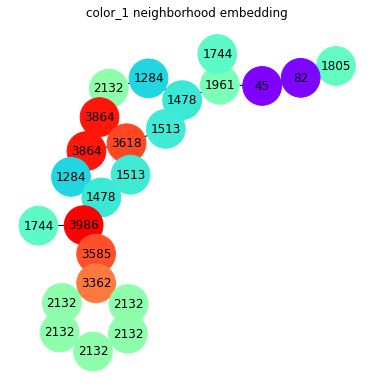

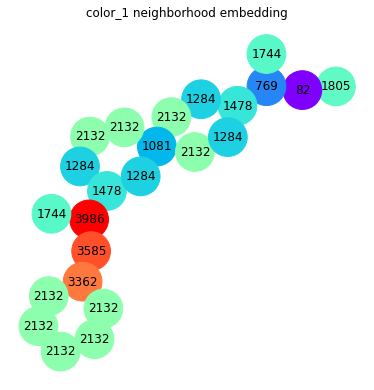

In [7]:
render_color_graph(mol_1_color_graph, 'color_1')
render_color_graph(mol_2_color_graph, 'color_1')

You can still see how similar these molecules are after 1 hop.

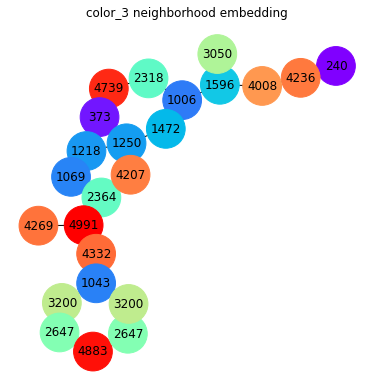

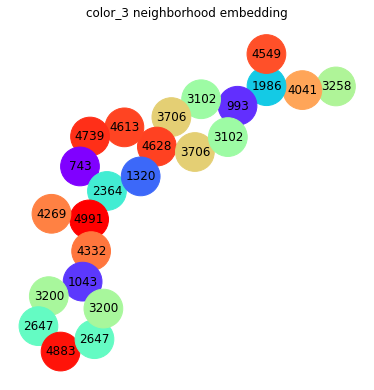

In [38]:
render_color_graph(mol_1_color_graph, 'color_3')
render_color_graph(mol_2_color_graph, 'color_3')

Even at the 4th hop the molecules are still similar, This is because the subgraphs of size 4 starting at the bottom left section are identical. The other subgraphs diverge into different colors 

In [9]:
graph_node_colors = cr._compute_node_colors(mol,3,5000)
print('0 hop')
print(graph_node_colors.iloc[0].value_counts())
# there are no nodes that have the same 2 hop neighborhood
print('1 hop')
print(graph_node_colors.iloc[1].value_counts())
print('2 hop')
print(graph_node_colors.iloc[2].value_counts())


0 hop
3036    13
4120     2
4731     2
Name: color_0, dtype: int64
1 hop
2132    4
3585    2
1284    2
2900    2
2417    1
1961    1
1744    1
3362    1
4516    1
82      1
1805    1
Name: color_1, dtype: int64
2 hop
1632    1
2833    1
4264    1
4863    1
2678    1
210     1
3948    1
626     1
4611    1
3438    1
2840    1
4366    1
3227    1
1051    1
360     1
933     1
1896    1
Name: color_2, dtype: int64
